# **Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình LSTM**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình LSTM để phát hiện điểm bất thường trên tập dữ liệu lưu lượng mạng KDD99.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
#try:
 #   path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
#except:
 #   print('Error downloading')
  #  raise

#print(path) 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Nam3(2022-2023)/HK_2/Phương pháp học máy/Colab Notebooks/LAB5/kddcup.data_10_percent.gz')
print("Read {} rows.".format(len(df)))

Read 494020 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(494020, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97277
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-105-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-105-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-105-52e386ca073c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

In [ ]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148206, 120), (148206,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/3
271/271 [==============================] - 8s 21ms/step - loss: 0.0965 - accuracy: 0.8810 - val_loss: 0.0128 - val_accuracy: 0.9837
Epoch 2/3
271/271 [==============================] - 5s 18ms/step - loss: 0.0151 - accuracy: 0.9815 - val_loss: 0.0176 - val_accuracy: 0.9799
Epoch 3/3
271/271 [==============================] - 5s 18ms/step - loss: 0.0121 - accuracy: 0.9863 - val_loss: 0.0138 - val_accuracy: 0.9839


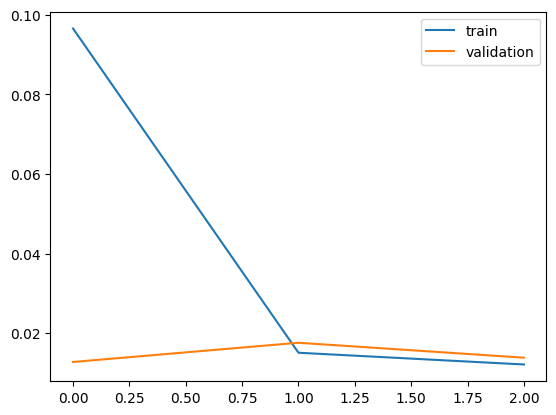

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 [==============================] - 3s 8ms/step - loss: 0.0144 - accuracy: 0.9834


4632/4632 [==============================] - 16s 3ms/step
Confusion Matrix:
[[ 27751   1360]
 [  1010 118085]]


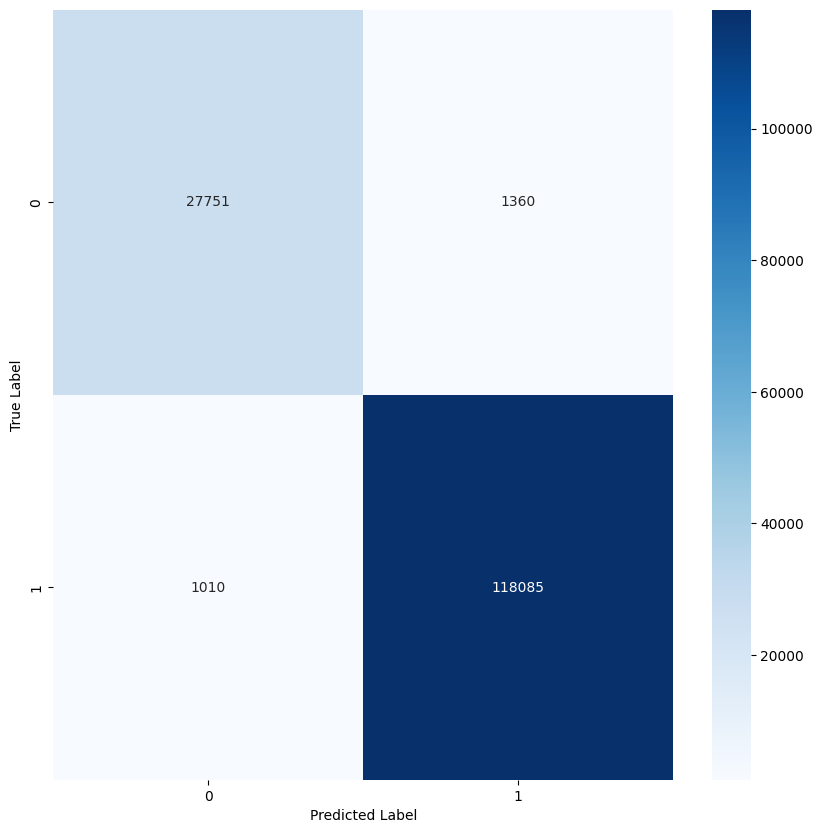

4632/4632 [==============================] - 15s 3ms/step
Precision: 0.98395270197019
Recall: 0.9840087445852395
F1-score: 0.9839721200485684


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Dự đoán nhãn cho tập kiểm tra
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.numpy(), axis=1)

# Tính toán confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# In confusion matrix
print("Confusion Matrix:")
print(cm)

# Vẽ heatmap cho confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict the labels for the test set
y_pred = model.predict(x_test)

# Convert the predicted labels to binary
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculate the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





# YÊU CẦU 2 : Binary Classification

In [ ]:
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip" && unzip awscliv2.zip && sudo ./aws/install

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: aws/dist/awscli/examples/cloudfront/get-field-level-encryption-config.rst  
  inflating: aws/dist/awscli/examples/cloudfront/create-public-key.rst  
  inflating: aws/dist/awscli/examples/cloudfront/delete-field-level-encryption-config.rst  
  inflating: aws/dist/awscli/examples/cloudfront/create-distribution.rst  
  inflating: aws/dist/awscli/examples/cloudfront/delete-distribution.rst  
  inflating: aws/dist/awscli/examples/cloudfront/update-cloud-front-origin-access-identity.rst  
  inflating: aws/dist/awscli/examples/cloudfront/get-field-level-encryption-profile.rst  
  inflating: aws/dist/awscli/examples/cloudfront/update-field-level-encryption-profile.rst  
  inflating: aws/dist/awscli/examples/cloudfront/list-public-keys.rst  
  inflating: aws/dist/awscli/examples/cloudfront/get-field-level-encryption.rst  
  inflating: aws/dist/awscli/examples/cloudfront/untag-resource.rst  
  inflating: aws/dist/awscli/exampl

In [ ]:
! /usr/local/bin/aws --version

aws-cli/2.11.24 Python/3.11.3 Linux/5.15.107+ exe/x86_64.ubuntu.20 prompt/off


In [ ]:
!aws s3  --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/"


usage: aws [options] <command> <subcommand> [<subcommand> ...] [parameters]
To see help text, you can run:

  aws help
  aws <command> help
  aws <command> <subcommand> help

aws: error: argument subcommand: Invalid choice, valid choices are:

ls                                       | website                                 
cp                                       | mv                                      
rm                                       | sync                                    
mb                                       | rb                                      
presign                                 



In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/"

                           PRE Original Network Traffic and Log data/
                           PRE Processed Traffic Data for ML Algorithms/


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Original Network Traffic and Log data/"

                           PRE Friday-02-03-2018/
                           PRE Friday-16-02-2018/
                           PRE Friday-23-02-2018/
                           PRE Thursday-01-03-2018/
                           PRE Thursday-15-02-2018/
                           PRE Thursday-22-02-2018/
                           PRE Tuesday-20-02-2018/
                           PRE Wednesday-14-02-2018/
                           PRE Wednesday-21-02-2018/
                           PRE Wednesday-28-02-2018/
2018-10-10 11:52:09          0 


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"

2018-10-11 16:02:25          0 
2018-10-11 16:02:49  352368373 Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:10  333723605 Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:33  382840456 Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:59 4054925350 Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:38  107842858 Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:48  375945899 Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:20  382636202 Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:44  358223333 Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:12  328893673 Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:33  209249758 Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


In [ ]:
!aws s3 cp --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv" "/content/drive/MyDrive/Nam3(2022-2023)/HK_2/Phương pháp học máy/Colab Notebooks/Lab5"

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/Nam3(2022-2023)/HK_2/Phương pháp học máy/Colab Notebooks/Lab5/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Nam3(2022-2023)/HK_2/Phương pháp học máy/Colab Notebooks/Lab5/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv',nrows=10000)
print("Read {} rows.".format(len(df)))
df

Read 10000 rows.


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,21,6,16/02/2018 10:17:11,3,1,1,0,0,0,0,...,40,0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest
9996,21,6,16/02/2018 10:17:11,3,1,1,0,0,0,0,...,40,0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest
9997,21,6,16/02/2018 10:17:11,3,1,1,0,0,0,0,...,40,0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest
9998,21,6,16/02/2018 10:17:11,3,1,1,0,0,0,0,...,40,0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest


In [4]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(10000, 80)

In [5]:
df.dtypes

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object

In [6]:
df.groupby('Label')['Label'].count()

Label
Benign                       101
DoS attacks-SlowHTTPTest    9899
Name: Label, dtype: int64

In [7]:
def remove_single_value_columns(dataframe):
    col_names = dataframe.columns
    unique_values = [len(dataframe[col].unique()) for col in col_names]

    col_unique_df = pd.DataFrame({'ColName': col_names, 'UniqueValues': unique_values})
    single_val_cols_df = col_unique_df[col_unique_df['UniqueValues'] == 1]
    return col_unique_df, single_val_cols_df


def sort_data_by_time(dataframe, time_col="Timestamp"):
    sorted_data = dataframe.sort_values(by=[time_col], ascending=True)
    return sorted_data


# Loại bỏ các cột chỉ có 1 giá trị
col_unique_df, single_val_cols_df = remove_single_value_columns(df)
df = df.drop(columns=single_val_cols_df['ColName'].values)

# Sắp xếp dữ liệu theo thời gian
df = sort_data_by_time(df)

df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0,0.0,0,0,0.0,0.000000,0,0,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,21,6,16/02/2018 10:17:11,3,1,1,0,0,0,0,...,40,0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-SlowHTTPTest
1521,0,0,16/02/2018 10:17:12,112640628,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,5.656854,56300000,56300000,Benign
7122,0,0,16/02/2018 10:20:01,112640543,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,7.778175,56300000,56300000,Benign
8883,22,6,16/02/2018 10:23:35,8203225,9,8,1063,2273,744,0,...,32,1911468,0.0,1911468,1911468,6291734.0,0.000000,6291734,6291734,Benign


In [8]:
df.drop('Timestamp', axis=1, inplace=True)

3.ENCODE DỮ LIỆU SỐ VÀ CHỮ

In [9]:

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [10]:
text_col = []

for i in range(df.shape[1]):
  if str(df.dtypes[i]) != "int64" and str(df.dtypes[i]) != "float64":
    if str(df.columns[i]) != "Label":
      text_col.append(df.columns[i])
     

In [11]:
text_col 

[]

In [12]:
#encoding feature vector

for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)
     

In [13]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2,19.825004,0.049728,2.786704,8.260939,4.728421,16.397953,0.074076,4.496813,12.116308,6.120489,...,-7.162795,25.975180,-0.01,14.726200,50.955059,2.370180,-0.010010,2.369248,2.370619,Benign
0,-0.048500,-13.958237,15.401075,0.720903,-0.125598,-0.044337,-0.011484,-0.065673,-0.019493,-0.053629,...,-14.410680,-0.023598,-0.01,-0.018046,-0.031908,15.078392,-0.006520,15.073112,15.080742,Benign
4,-0.035662,0.049728,-0.067512,-0.033101,-0.015279,-0.044337,-0.011484,-0.065673,-0.019493,-0.053629,...,-7.162795,-0.023598,-0.01,-0.018046,-0.031908,-0.066513,-0.010010,-0.066611,-0.066440,Benign
1,-0.048500,-13.958237,15.401213,0.720903,-0.125598,-0.044337,-0.011484,-0.065673,-0.019493,-0.053629,...,-14.410680,-0.023598,-0.01,-0.018046,-0.031908,15.078392,-0.003369,15.073112,15.080742,Benign
3,-0.048500,-13.958237,15.401084,0.720903,-0.125598,-0.044337,-0.011484,-0.065673,-0.019493,-0.053629,...,-14.410680,-0.023598,-0.01,-0.018046,-0.031908,15.078392,-0.007944,15.073112,15.080742,Benign


In [14]:
df.loc[df["Label"] != "Benign.", "Label"] = 1
df.loc[df["Label"] == "Benign.", "Label"] = 0

In [15]:
y = df['Label']
df.drop('Label',axis=1,inplace=True)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {X_train.shape, Y_train.shape}")
print(f"Normal test count: {X_test.shape, Y_test.shape}")

Normal train count: ((7000, 66), (7000,))
Normal test count: ((3000, 66), (3000,))


In [51]:

# Convert Y_train and Y_test to one-hot encoding
Y_train = tf.one_hot(Y_train, 2)
Y_test = tf.one_hot(Y_test, 2)

# Convert X_train and X_test to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)





5.KIẾN TRÚC MÔ HÌNH

In [65]:


model = keras.Sequential()
model.add(keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()





Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                2112      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,178
Trainable params: 2,178
Non-trainable params: 0
_________________________________________________________________


6. HUẤN LUYỆN MÔ HÌNH

In [66]:
history = model.fit(X_train, Y_train, epochs=3, batch_size=1024, validation_split=0.2)

Epoch 1/3
8/8 [==============================] - 2s 27ms/step - loss: 0.2534 - accuracy: 0.5806 - val_loss: 0.2155 - val_accuracy: 0.9980
Epoch 2/3
8/8 [==============================] - 0s 9ms/step - loss: 0.2036 - accuracy: 0.8839 - val_loss: 0.1666 - val_accuracy: 0.9980
Epoch 3/3
8/8 [==============================] - 0s 10ms/step - loss: 0.1605 - accuracy: 0.9693 - val_loss: 0.1307 - val_accuracy: 0.9980


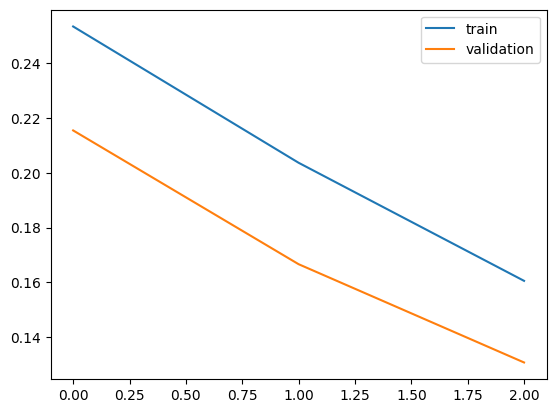

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

7. ĐÁNH GIÁ MÔ HÌNH

In [68]:

score1 = model.evaluate(X_train, Y_train, batch_size=1024)

10/10 [==============================] - 0s 5ms/step - loss: 0.1372 - accuracy: 0.9902
